In [1]:
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_validate,  cross_val_predict
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay

In [10]:
import sklearn
sklearn.__version__

'1.2.0'

In [2]:
df = pd.read_csv('../../../data/nerpa_scoring_table.tsv', sep='\t')
df['is_correct'] = df['is_correct'].astype(bool)
n_domains = (df['substrate'] == 'Pro').sum()
n_predictions = int(df.shape[0] / n_domains)
df['id'] = np.repeat(np.arange(n_domains), n_predictions)

df.head(3)

,substrate,is_correct,aa10_score1,aa10_score2,aa10_score3,aa10_score4,aa34_score1,aa34_score2,aa34_score3,aa34_score4,svm_single_amino_score,svm_small_cluster_score,svm_large_cluster_score,svm_class_score,num_sources,id
0,Aad,False,0.2,0.2,0.2,0.2,0.382353,0.382353,0.382353,0.382353,0.0,0.0,0.0,0.000000,1,0
1,Abu,False,0.7,0.7,0.7,0.7,0.529412,0.529412,0.529412,0.529412,0.0,0.0,0.0,1.922728,1,0
2,Ala,False,0.7,0.7,0.7,0.7,0.617647,0.617647,0.617647,0.617647,0.0,0.0,0.0,1.922728,1,0


In [3]:
features = ['aa10_score3', 'aa34_score4', 'svm_single_amino_score', 'svm_small_cluster_score',
    'svm_large_cluster_score', 'svm_class_score']

dfX = df[features].rename(columns={'aa10_score3': 'aa10_score', 'aa34_score4': 'aa34_score', 'svm_class_score': 'svm_physiochemical_class_score'})
dfY = df['is_correct']
# X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.2, stratify=dfY)

In [4]:
def brier(y, y_pred, c=0):
    mask = y == c
    # print(y.shape, y_pred.shape)
    return np.power(y[mask] - y_pred[mask], 2).mean()

scoring = {
    'f1': 'f1',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'roc_auc': 'roc_auc',
    'prec_macro_w': 'precision_weighted',
    'rec_macro_w': 'recall_weighted',
    'roc_auc_ovo_w': 'roc_auc_ovo_weighted',
    'roc_auc_ovo': 'roc_auc_ovo',
    'brier_pos': make_scorer(brier, c=1, greater_is_better=False),
    'brier_neg': make_scorer(brier, c=0, greater_is_better=False),
}

In [5]:
params = {
    'n_estimators': 100,
    'class_weight': None,
    'criterion': "gini",
    'max_depth': 5,
    'min_samples_split': 10
}

cv = GroupKFold(n_splits=5)
clf = RandomForestClassifier(random_state=0, **params)
scores = cross_validate(clf, dfX, dfY, scoring=scoring, cv=cv, groups=df['id'])

df_scores = pd.DataFrame(scores).T
df_scores['mean'] = df_scores[[0,1,2,3,4]].mean(axis=1)
df_scores['std'] = df_scores[[0,1,2,3,4]].std(axis=1)
df_scores

,0,1,2,3,4,mean,std
fit_time,3.225782,2.983049,2.993514,2.987291,3.185869,3.075101,0.120224
score_time,0.349844,0.347690,0.349019,0.343345,0.343276,0.346635,0.003131
test_f1,0.645078,0.616202,0.637865,0.635417,0.645669,0.636046,0.011955
test_prec_macro,0.956217,0.934355,0.935340,0.940355,0.944212,0.942096,0.008839
test_rec_macro,0.746988,0.735919,0.748634,0.745701,0.750822,0.745613,0.005747
test_roc_auc,0.945064,0.928508,0.923859,0.938615,0.930483,0.933306,0.008466
test_prec_macro_w,0.985206,0.983954,0.984217,0.984571,0.985158,0.984621,0.000557
test_rec_macro_w,0.985940,0.985170,0.985376,0.985632,0.986115,0.985647,0.000389
test_roc_auc_ovo_w,0.945064,0.928508,0.923859,0.938615,0.930483,0.933306,0.008466
test_roc_auc_ovo,0.945064,0.928508,0.923859,0.938615,0.930483,0.933306,0.008466


In [6]:
probs = cross_val_predict(clf, dfX, dfY, cv=cv, groups=df['id'], method='predict_proba')

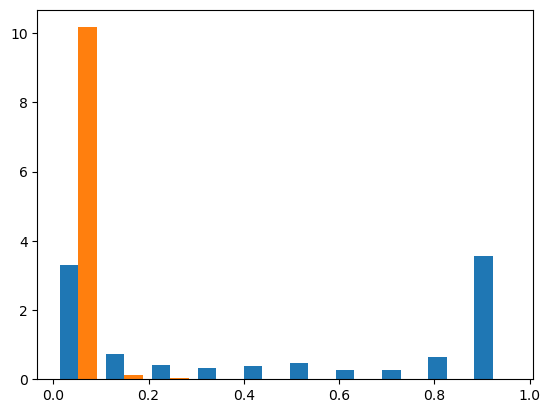

In [7]:
df['prob'] = probs[:, 1]
_ = plt.hist([df.loc[df['is_correct'], 'prob'], df.loc[~df['is_correct'], 'prob']], density=True)

In [8]:
clf.fit(dfX, dfY)
pd.Series(clf.feature_importances_, index=clf.feature_names_in_)


aa10_score                        0.142924
aa34_score                        0.294917
svm_single_amino_score            0.396909
svm_small_cluster_score           0.099667
svm_large_cluster_score           0.047797
svm_physiochemical_class_score    0.017785
dtype: float64

In [9]:
joblib.dump(clf, 'specificity-model-unbalanced.joblib')

['specificity-model-unbalanced.joblib']